In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Financial correlation for FED impact in macro

This notebook explores the impact of the FED policies on macroeconomic variables.
It describes the relations by the correlations between their historical values.

### FED controlled series:
- Federal Funds Effective Rate
- 10Y-2Y Treasury Constant Maturity
- Balance Sheet: Total Assets
### macroeconomic variables, for United States:
- Crude Oil Price: WTI
- Sticky Price Consumer Price Index less Food and Energy
- Velocity of M2 Money Stock
- Unemployment Rate
- GDP
- gold
- SP500

## Data
- 1970 - 2023
- main source https://fred.stlouisfed.org/
- gold source
    - https://datahub.io/AcckiyGerman/gold-prices#data
    - https://www.nasdaq.com/market-activity/commodities/gc:cmx/historical
- sp500 source
    - https://www.investing.com/indices/us-spx-500-historical-data

## Approach
- unify timeframe and aggregate into monthly resolution
- merge data
- build percent variation and shifted variables
- rolling scale series to z-score (mean 0, standard deviation 1)
- alculate pairwise correlation coefficients, as the median of the rolling correlation across time for every pair
- plot the most relevant and correlated pairs of series
- add the rolling correlation across time to each pair plot

## Results
- high-interest rates are related to:
    - high GDP 6 months before
    - low unemployment rate
    - high m2 money velocity, strong correlation after early 2000’s
    - high CPI 12 months after
- high treasury bond inversion 10-2 years is related to:
    - high unemployment rate, strong correlation
    - high GDP 6 months before
    - low GDP rate y/y 12 months before
- high balance sheet is related to:
    - high GDP 6 months before
    - low unemployment 6 months before
- high balance sheet rate y/y is related to:
    - low GDP rate y/y
    - low unemployment rate 6 months after
    
- balance sheet correlations invert after 2019Q4, related to its sudden increase during the event of September in the repo market https://en.wikipedia.org/wiki/September_2019_events_in_the_U.S._repo_market
- no strong correlation between FED policies and oil, gold price

## Notes
- Series shifted a positive number of months reflect delayed sequences, which correspond with a number of periods in the past relative to the fixed series. Moving a GDP +6 months means bringing to the present data from the past.
- Spearman and Kendall-Tau methods for calculating correlation coefficients are not implemented as rolling correlation in pandas. It would be worthy to check them to be more robust against non-linearity in order to evaluate whether variables are at least monotonically correlated.
- SP500 has been analyzed by taking its logarithm to alleviate the exponential distribution, with no remarkable differences.

## Insights
- Go back to develop code and explore data to PyCharm while keeping the notebook just to display notes, results, plots, and high-level code.
- When working with time dependant data apply any transformation in a rolling manner, even if is not inferential or simply descriptive. This applies to scaling, correlation, handling missing data...

## Next
- Research oil and gold data in a smaller time resolution scale. Since their sizes are smaller than GDP or balance sheet, they move in shorter time frames.
- Analyze relationships using supervised machine learning instead of correlation. This would involve taking Fed policy series as x and each impacted variable as y. Feature importance and partial dependency plots might produce insight variable relationships. The accuracy of the model for each target series can select those predictable by the input variables.

In [2]:
import pandas as pd
import numpy as np

import datapackage
from functools import reduce
from datetime import datetime
from pandas import DataFrame, Series

import matplotlib.pyplot as plt

import seaborn as sns

sns.set_theme()

In [3]:
col_date = "DATE"
col_month = "month"

col_gold = "gold"
col_interest_rate = "Federal Funds Effective Rate"
col_yield_spread = "10Y-2Y Treasury Constant Maturity"
col_balance_sheet = "Balance Sheet: Total Assets"
col_oil = "Crude Oil Price: WTI"
col_cpi = "Sticky Price Consumer Price Index less Food and Energy"
col_m2v = "Velocity of M2 Money Stock"
col_unemployment = "Unemployment Rate"
col_gdp = "GDP"
col_gold = "gold"
col_sp500 = "SP500"

alias_dict = {
    "RIFSPFFNB": col_interest_rate,
    "T10Y2Y": col_yield_spread,
    "QBPBSTAS": col_balance_sheet,
    "DCOILWTICO": col_oil,
    "CORESTICKM159SFRBATL": col_cpi,
    "M2V": col_m2v,
    "UNRATE": col_unemployment,
}

suffix_pct_chg = "_percent_change_y/y"

col_policy_list = [
    col_interest_rate,
    col_yield_spread,
    col_balance_sheet,
    col_balance_sheet + suffix_pct_chg,
]

year_start = 1970
year_end = 2023
rolling_window_month_count = 12 * 10

In [4]:
def get_month_start(series: Series) -> Series:
    return series.values.astype("<M8[M]")

def agg_monthly(df: DataFrame) -> DataFrame:
    df[col_date] = get_month_start(df[col_date])
    # return df.set_index(col_date).resample("MS").median()
    return df.groupby(col_date, as_index=False).median()   

In [5]:
def get_df_gold_new():
    from datetime import datetime
    dateparse = lambda x: datetime.strptime(x, '%m/%d/%Y')

    df = pd.read_csv("data/gold_2023-02-22.csv", parse_dates=['Date'], date_parser=dateparse)
    df.columns = [col.upper() for col in df.columns]
    col_price = "CLOSE/LAST"
    col_gold_new = col_gold + "_new"

    return df[[col_date, col_price]].rename(columns={col_price: col_gold_new})

In [6]:
def get_df_gold_old():

    col_gold_old = col_gold + "_old"
    df = pd.read_csv("data/gold.csv", parse_dates=["date"])

    df.columns = [col.upper() for col in df.columns]

    return df.rename(columns={"PRICE": col_gold_old})[[col_date, col_gold_old]]

In [7]:
def get_df_gold():
    df = pd.merge(
        left=agg_monthly(get_df_gold_old()),
        right=agg_monthly(get_df_gold_new()),
        how="outer",
    )
    df[col_gold] = df[col_gold + "_old"].combine_first(df[col_gold + "_new"])
    return df[[col_date, col_gold]]

In [8]:
def get_df_sp500():
    df = pd.read_csv("data/S&P 500 Historical Data.csv", parse_dates=["Date"], thousands=",")

    df.columns = [col.upper() for col in df.columns]
    col = "SP500"
    df = df.rename(columns={"PRICE": col})[[col_date, col]]
    # df[col] = np.log(df[col])
    return agg_monthly(df.bfill())

In [9]:
df_list = [
    pd.date_range(f"{year_start}",f"{year_end}", freq="MS").to_frame(name=col_date)
] + [
    pd.read_csv(file_name, parse_dates=[col_date], na_values=".") for file_name in [
        "data/GDP.csv",
        "data/DCOILWTICO.csv",
        "data/RIFSPFFNB.csv",
        "data/T10Y2Y.csv",
        "data/CORESTICKM159SFRBATL.csv",
        "data/M2V.csv",
        "data/UNRATE.csv",
        "data/QBPBSTAS.csv",
        # "data/IQ12260.csv",
    ]
] + [
    get_df_gold(),
    get_df_sp500(),
]

In [10]:
def combine_df_list(df_list):
    df = reduce(
        lambda left,right: pd.merge(left=left, right=right, how="left"),
        map(agg_monthly, df_list)
    )
    df = df.set_index(col_date).sort_index()
    df = df[df.index >= f"{year_start}"]
    df.columns = [alias_dict.get(col, col) for col in df.columns]
    
    return df.bfill()

df = combine_df_list(df_list=df_list)
df_col_list = df.columns
df

,GDP,Crude Oil Price: WTI,Federal Funds Effective Rate,10Y-2Y Treasury Constant Maturity,Sticky Price Consumer Price Index less Food and Energy,Velocity of M2 Money Stock,Unemployment Rate,Balance Sheet: Total Assets,gold,SP500
DATE,,,,,,,,,,
1970-01-01,1051.200,23.805,9.250,0.815,6.628279,1.789,3.9,3373919.507,34.946,114.16
1970-02-01,1067.375,23.805,9.250,0.815,7.091447,1.804,4.2,3373919.507,34.994,114.16
1970-03-01,1067.375,23.805,7.750,0.815,7.030544,1.804,4.4,3373919.507,35.089,114.16
1970-04-01,1067.375,23.805,8.125,0.815,6.855423,1.804,4.6,3373919.507,35.623,114.16
1970-05-01,1086.059,23.805,7.880,0.815,6.985857,1.795,4.8,3373919.507,35.958,114.16
...,...,...,...,...,...,...,...,...,...,...
2022-09-01,26132.458,84.690,2.330,-0.370,6.392795,1.225,3.5,NaN,1681.100,3585.62
2022-10-01,26132.458,86.930,3.080,-0.395,6.364809,1.225,3.7,NaN,1669.200,3871.98
2022-11-01,NaN,85.790,3.830,-0.610,6.471178,NaN,3.6,NaN,1755.300,4080.11


In [11]:
def add_percent_change(df: DataFrame, col: str) -> DataFrame:
    
    freq_month_start = "MS"
    s = (
        df[col]
        .resample(freq_month_start)
        .median()
    ) + 1
    
    df[col + suffix_pct_chg] = s.pct_change(periods=12)
    return df

col_not_rate_list = [
    col_gdp,
    col_gold,
    col_balance_sheet,
    col_m2v,
    col_oil,
    col_sp500,
]

for col in col_not_rate_list:
    add_percent_change(df, col=col)

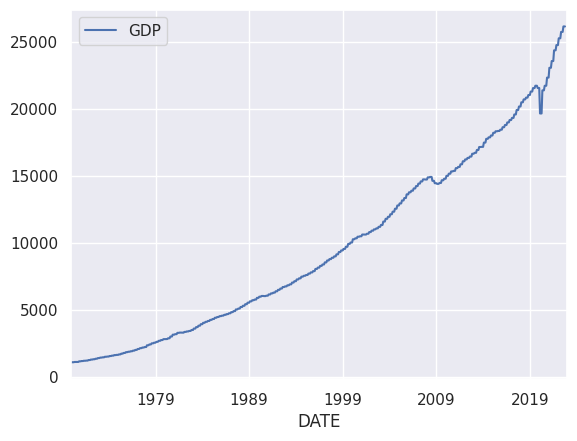

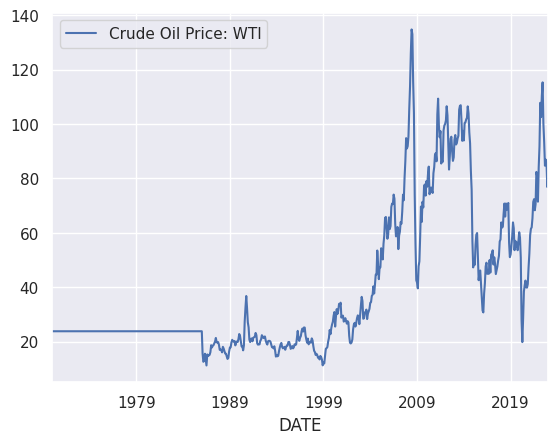

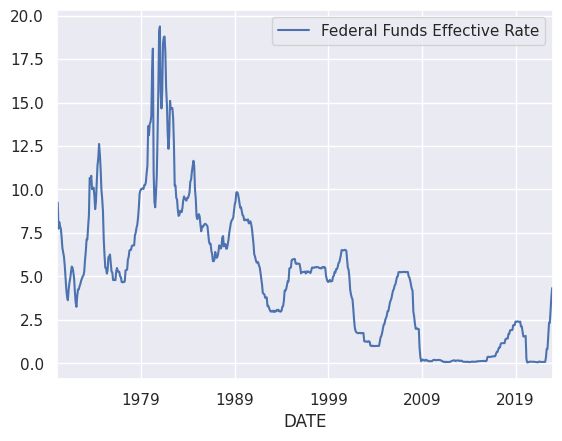

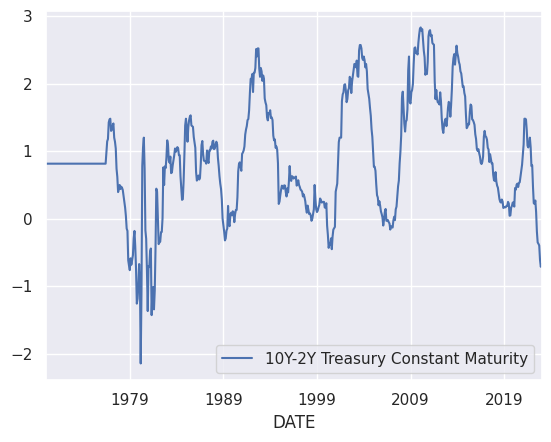

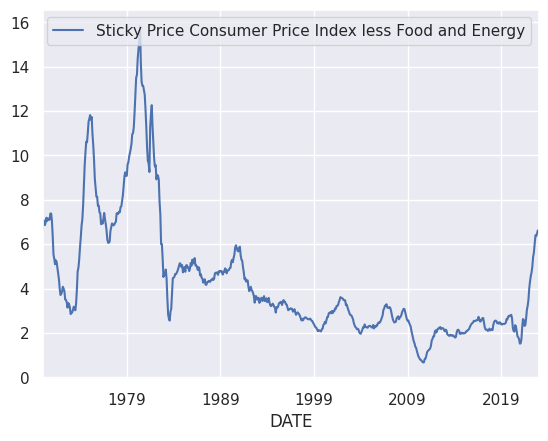

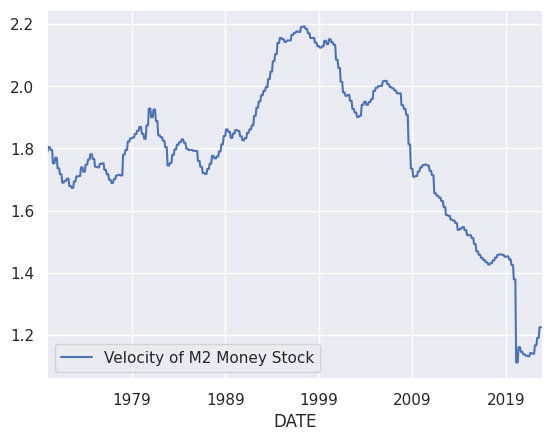

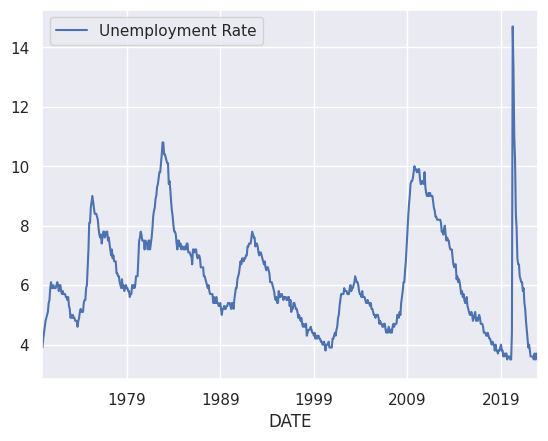

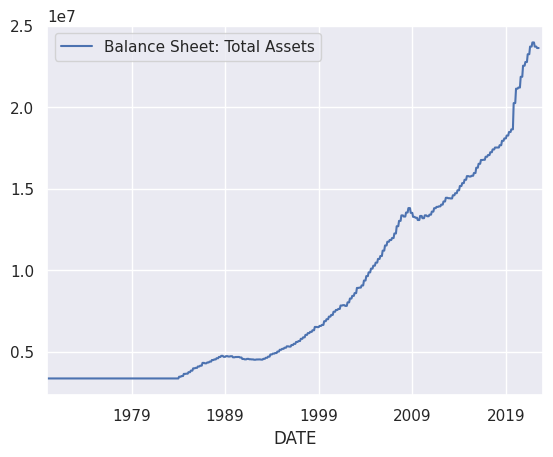

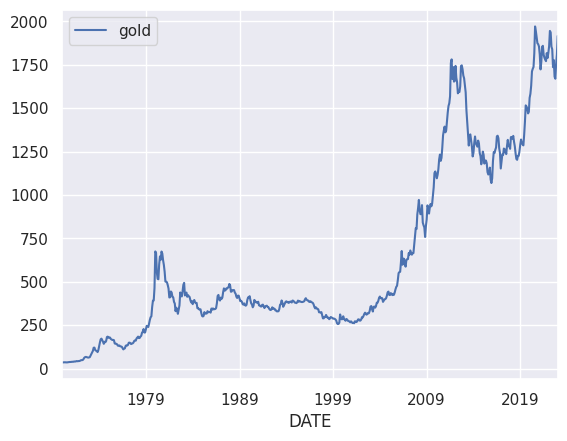

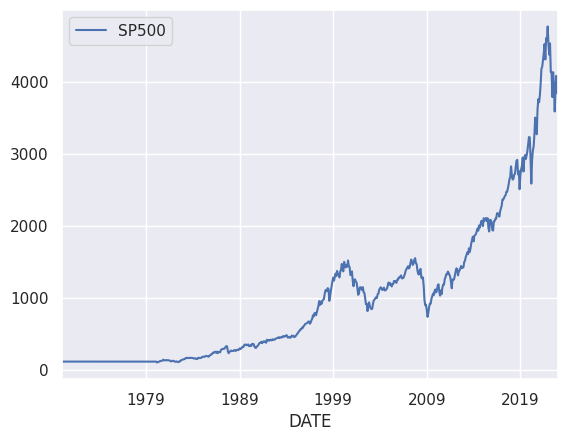

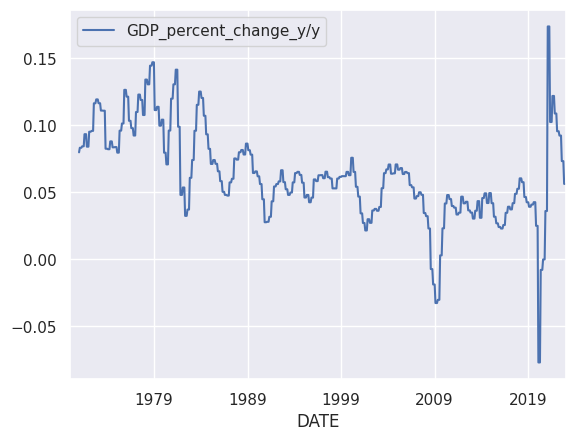

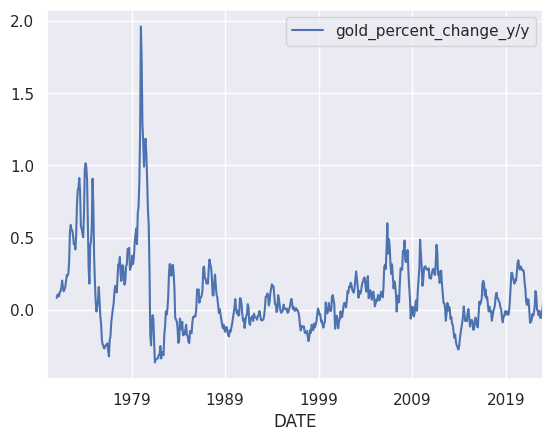

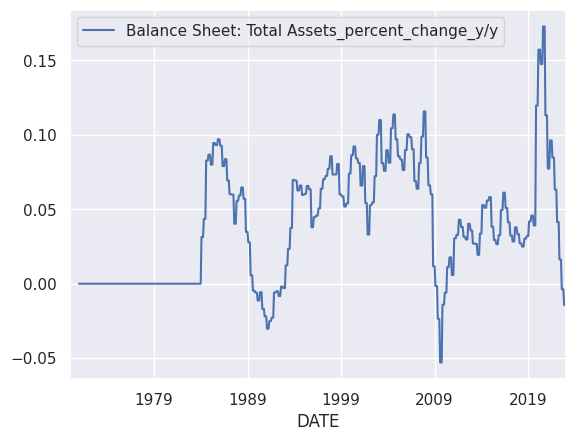

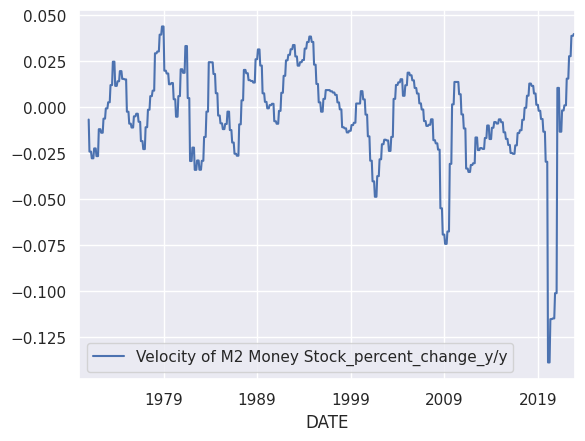

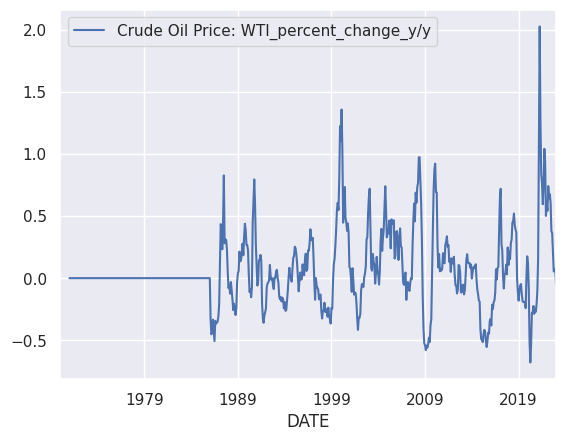

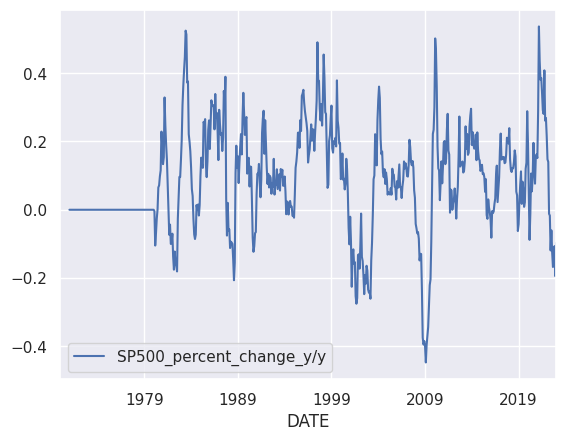

In [12]:
for col in df.columns:
    df[col].plot()
    plt.legend()
    plt.show()

In [13]:
def add_shifted(df: DataFrame, col: str, period_count: int) -> DataFrame:
    df = df.copy()
    df[f"{col}{period_count:+d}_months"] = df[col].shift(periods=period_count)
    return df

for period_count in [-24, -18, -12, -6, 6, 12, 18, 24]:
    for col in [
        col_gdp,
        col_oil,
        col_sp500,
        col_unemployment,
        col_cpi,
        col_gold,
        col_gdp + suffix_pct_chg,
        col_oil + suffix_pct_chg,
        col_gold + suffix_pct_chg,
        col_sp500 + suffix_pct_chg,
    ]:
        df = add_shifted(df=df, col=col, period_count=period_count)

In [14]:
def soften_series(df):
    return df.rolling("100D").median()
# df = soften_series(df)

In [15]:
df_mean = df.rolling(window=rolling_window_month_count).mean()
df_std = df.rolling(window=rolling_window_month_count).std()

df_scaled = (df - df_mean) / df_std
df_scaled

,GDP,Crude Oil Price: WTI,Federal Funds Effective Rate,10Y-2Y Treasury Constant Maturity,Sticky Price Consumer Price Index less Food and Energy,Velocity of M2 Money Stock,Unemployment Rate,Balance Sheet: Total Assets,gold,SP500,...,GDP+24_months,Crude Oil Price: WTI+24_months,SP500+24_months,Unemployment Rate+24_months,Sticky Price Consumer Price Index less Food and Energy+24_months,gold+24_months,GDP_percent_change_y/y+24_months,Crude Oil Price: WTI_percent_change_y/y+24_months,gold_percent_change_y/y+24_months,SP500_percent_change_y/y+24_months
DATE,,,,,,,,,,,,,,,,,,,,,
1970-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-01,2.331479,0.822478,2.044355,-1.978740,4.633395,-1.094935,-0.998182,NaN,0.944577,1.030666,...,1.627542,-1.243301,2.025598,0.795592,-0.165483,2.745882,-1.599978,-0.999966,1.509789,0.201056
2022-10-01,2.269854,0.923036,2.850945,-1.962863,4.205542,-1.077162,-0.876883,NaN,0.903091,1.336514,...,1.601006,-1.225063,1.837322,0.356489,-0.787421,2.478644,-1.567632,-0.855719,1.426363,-0.420683
2022-11-01,NaN,0.873339,3.523647,-2.197394,3.986397,NaN,-0.915008,NaN,1.237150,1.547916,...,1.874682,-1.149853,2.342687,0.280415,-0.959388,2.245479,0.077524,-0.915699,1.424695,0.474351


In [16]:
df_corr = (
    df_scaled
    .rolling(rolling_window_month_count)
    .corr()
    [col_policy_list].
    reset_index()
    .groupby("level_1")
    .median()
)
df_corr.head()

/tmp/ipykernel_26334/1223900784.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .median()


,Federal Funds Effective Rate,10Y-2Y Treasury Constant Maturity,Balance Sheet: Total Assets,Balance Sheet: Total Assets_percent_change_y/y
level_1,,,,
10Y-2Y Treasury Constant Maturity,-0.913369,1.000000,-0.590596,-0.312379
Balance Sheet: Total Assets,0.528392,-0.590596,1.000000,0.719367
Balance Sheet: Total Assets_percent_change_y/y,0.280039,-0.312379,0.719367,1.000000
Crude Oil Price: WTI,0.116095,0.059571,-0.070737,0.122868
Crude Oil Price: WTI+12_months,-0.211297,0.283919,-0.151851,-0.177762


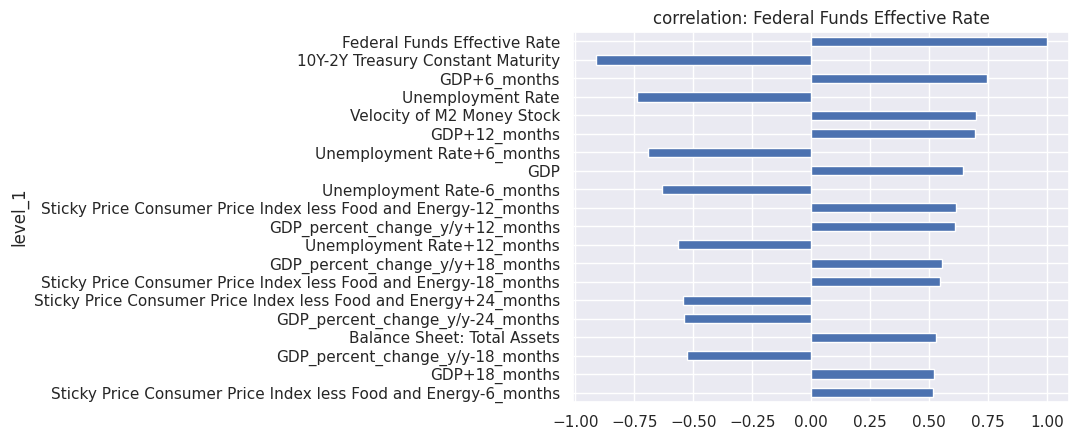

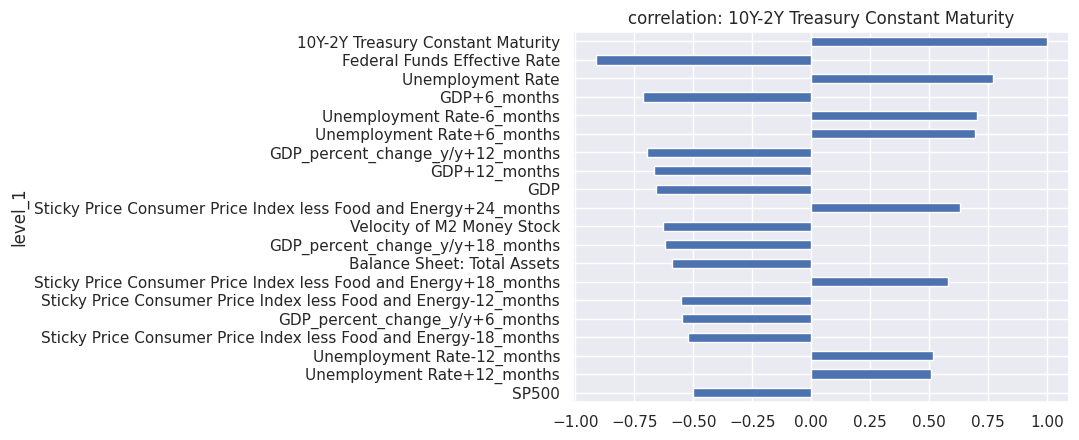

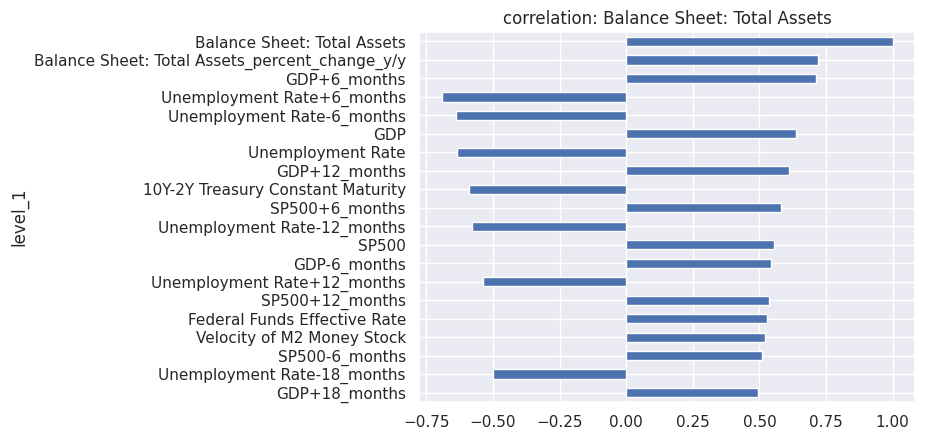

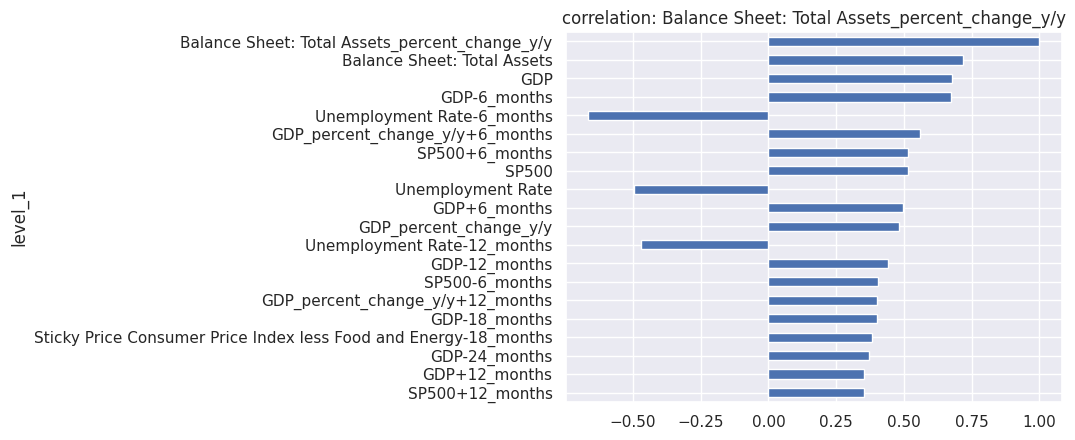

In [17]:
def get_top_corr(df: DataFrame, col: str) -> DataFrame:
    df = df.copy()
    col_abs = col + "_abs"
    df[col_abs] = df[col].abs()
    return df.sort_values(col_abs)[col].tail(20)

for col in col_policy_list:
    get_top_corr(df=df_corr, col=col).plot.barh()
    plt.title(f"correlation: {col}")
    plt.show()

In [18]:
corr_pair_list = [
    [col_interest_rate, col_yield_spread],
    [col_interest_rate, col_gdp + "+6_months"],
    [col_interest_rate, col_unemployment],
    [col_interest_rate, col_m2v],
    [col_interest_rate, col_cpi + "-12_months"],
    
    [col_yield_spread, col_unemployment],
    [col_yield_spread, col_gdp + suffix_pct_chg + "+12_months"],

    [col_balance_sheet, col_gdp + "+6_months"],
    [col_balance_sheet, col_unemployment + "+6_months"],

    [col_balance_sheet + suffix_pct_chg, col_gdp],
    [col_balance_sheet + suffix_pct_chg, col_unemployment + "-6_months"],
    [col_balance_sheet + suffix_pct_chg, col_sp500],
]

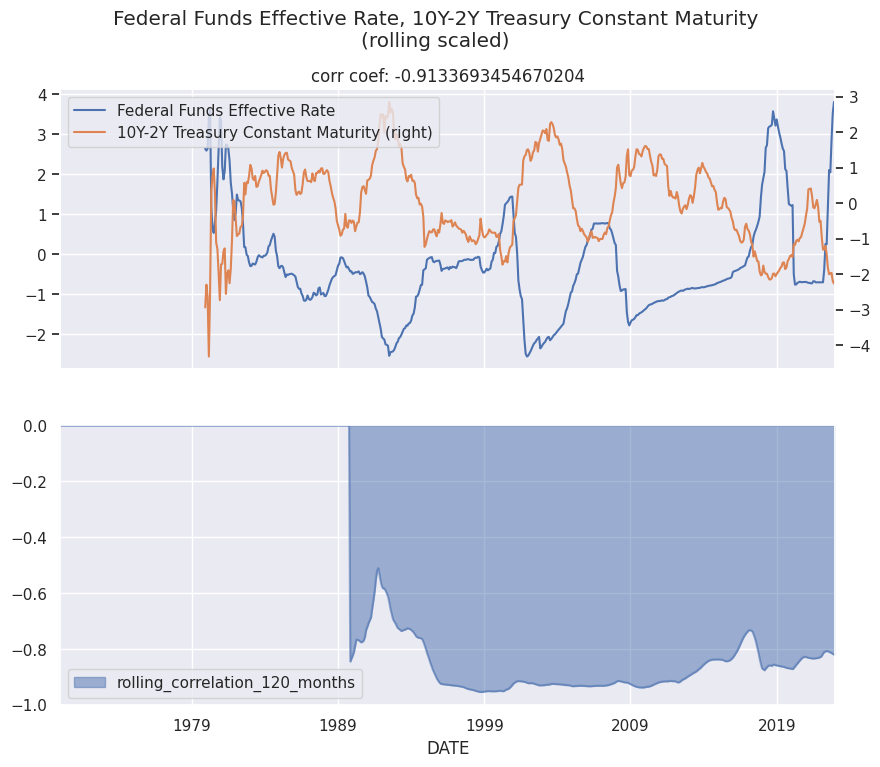

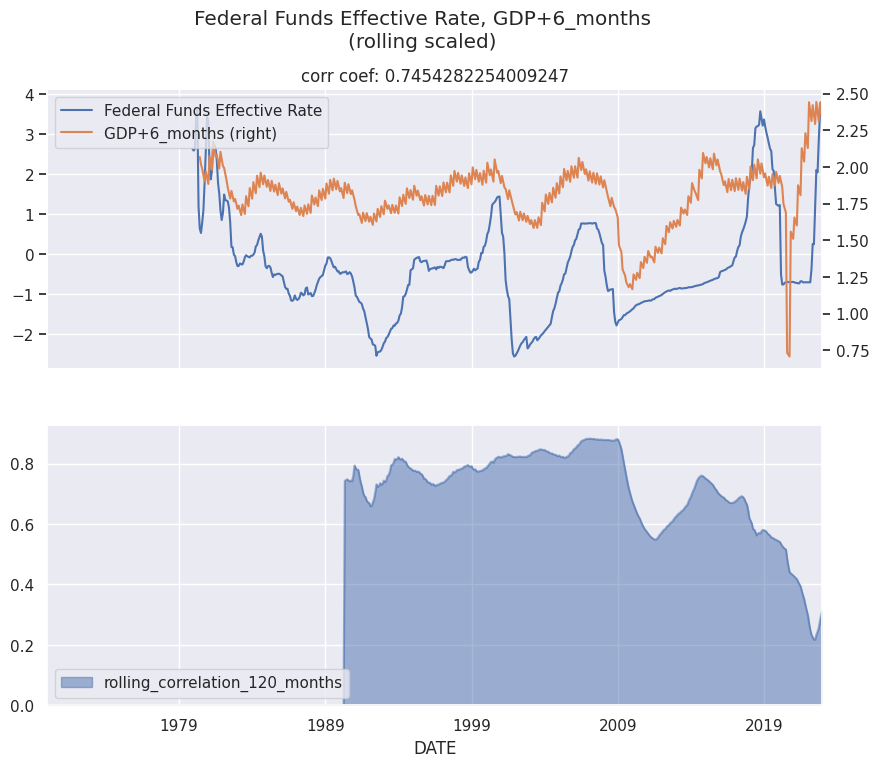

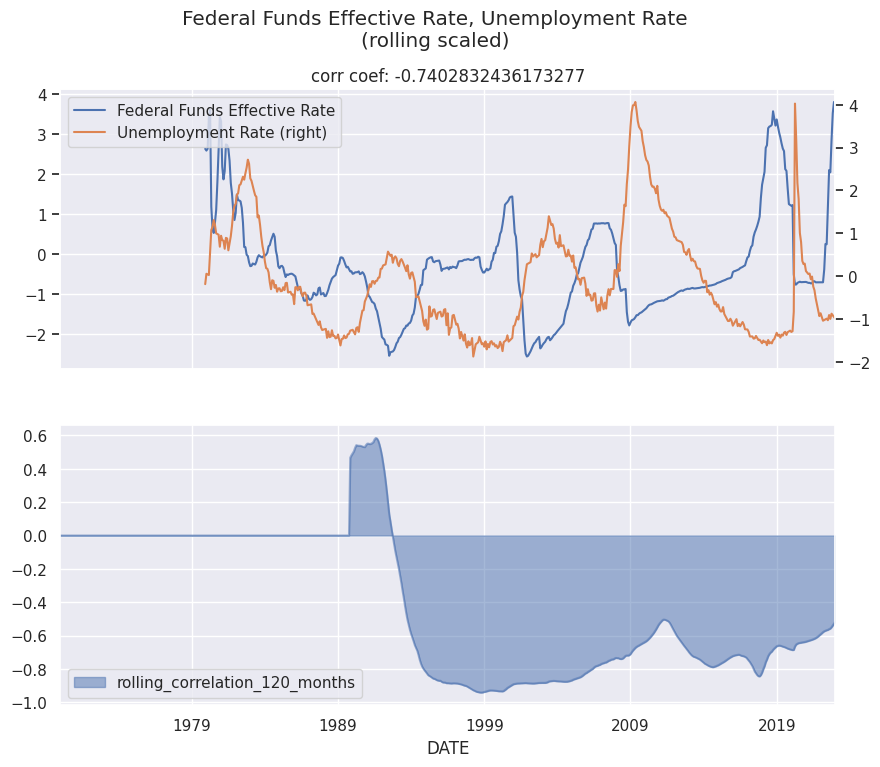

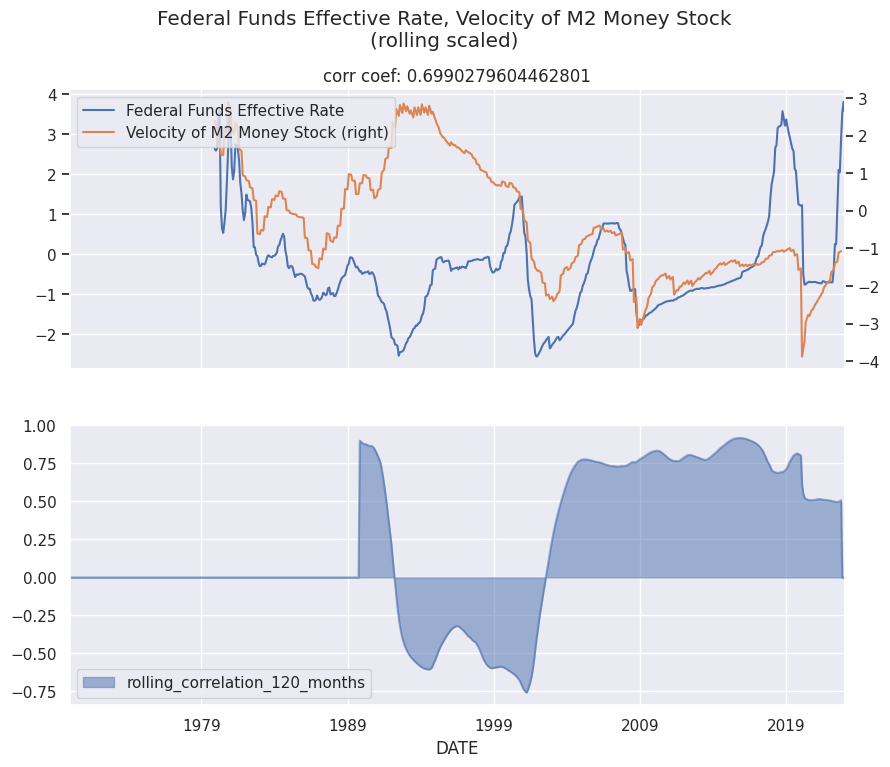

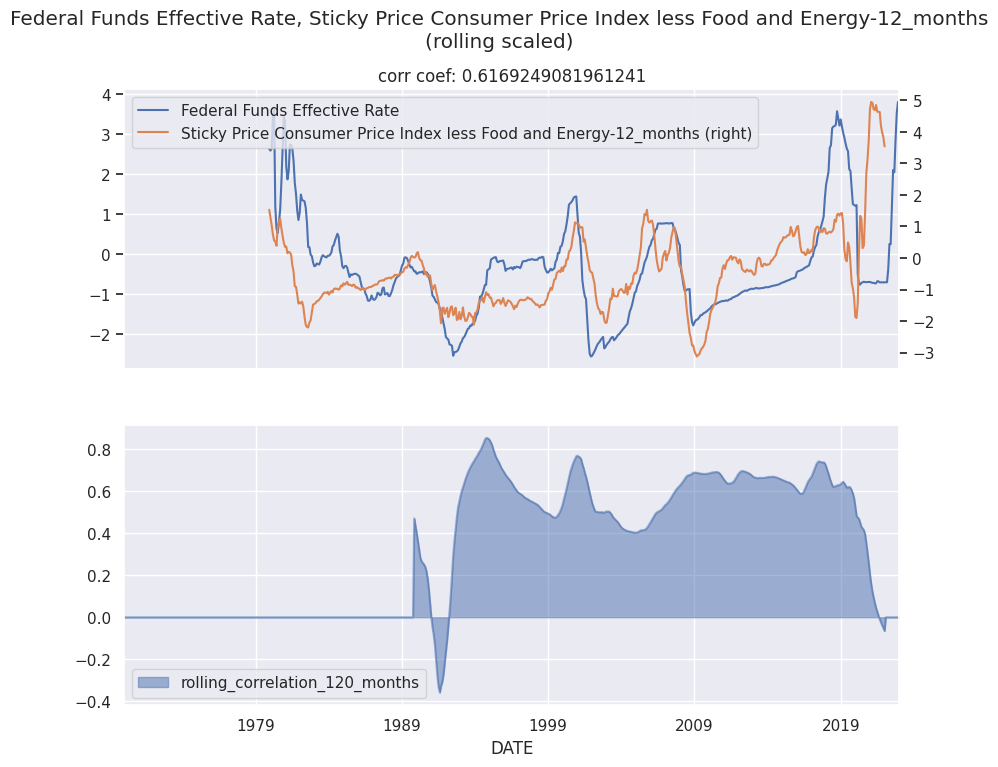

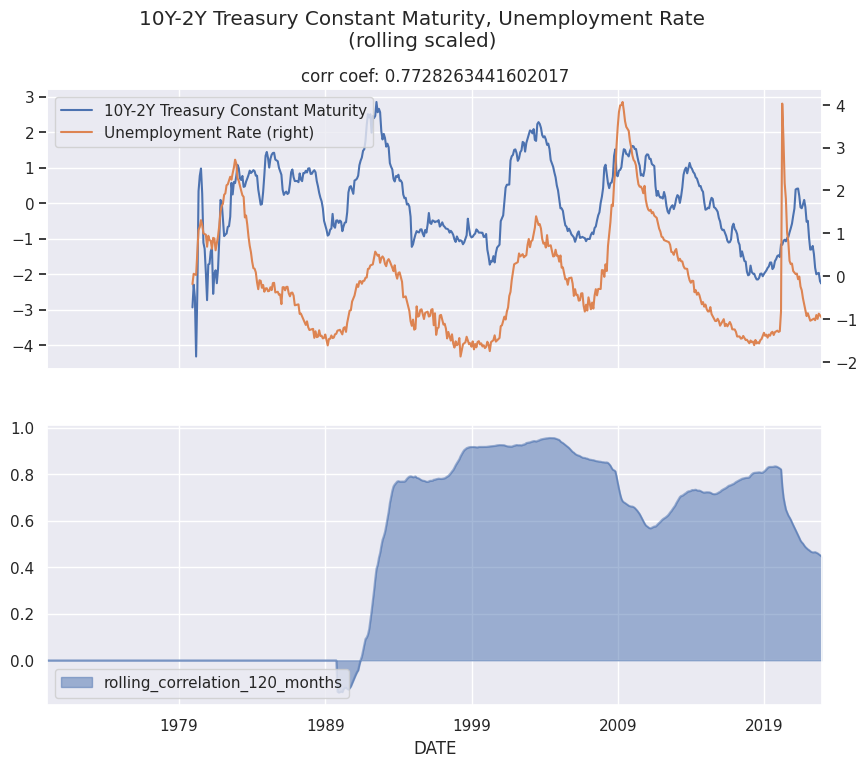

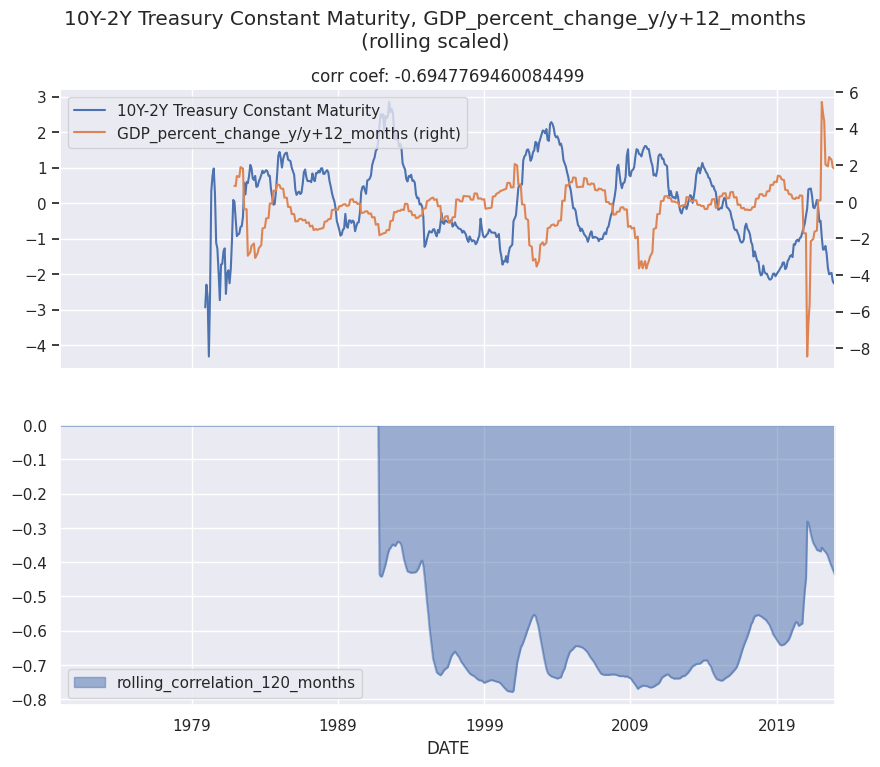

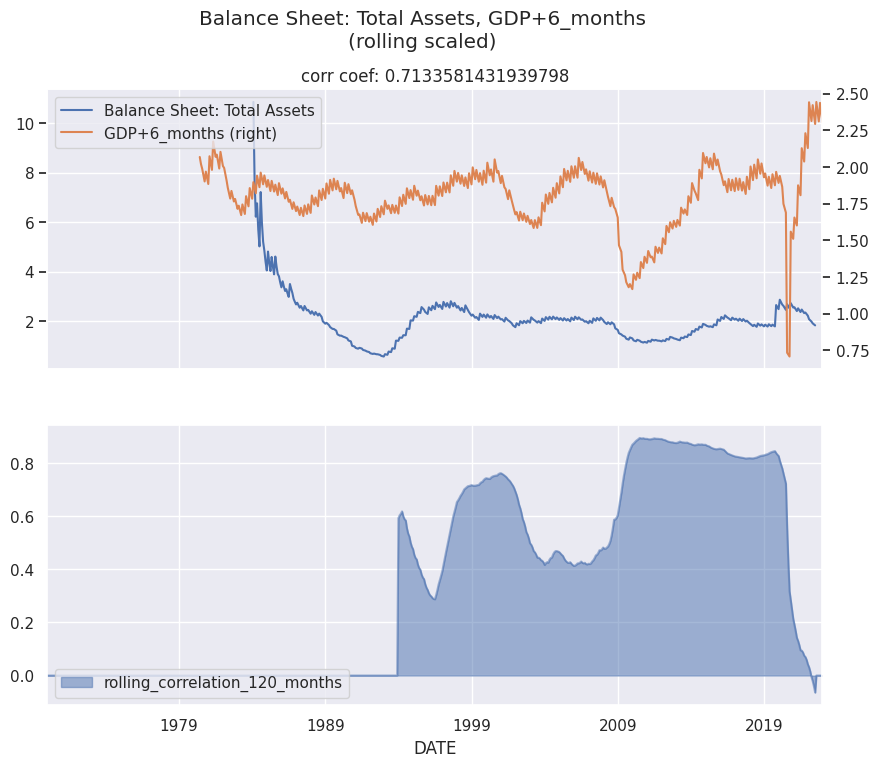

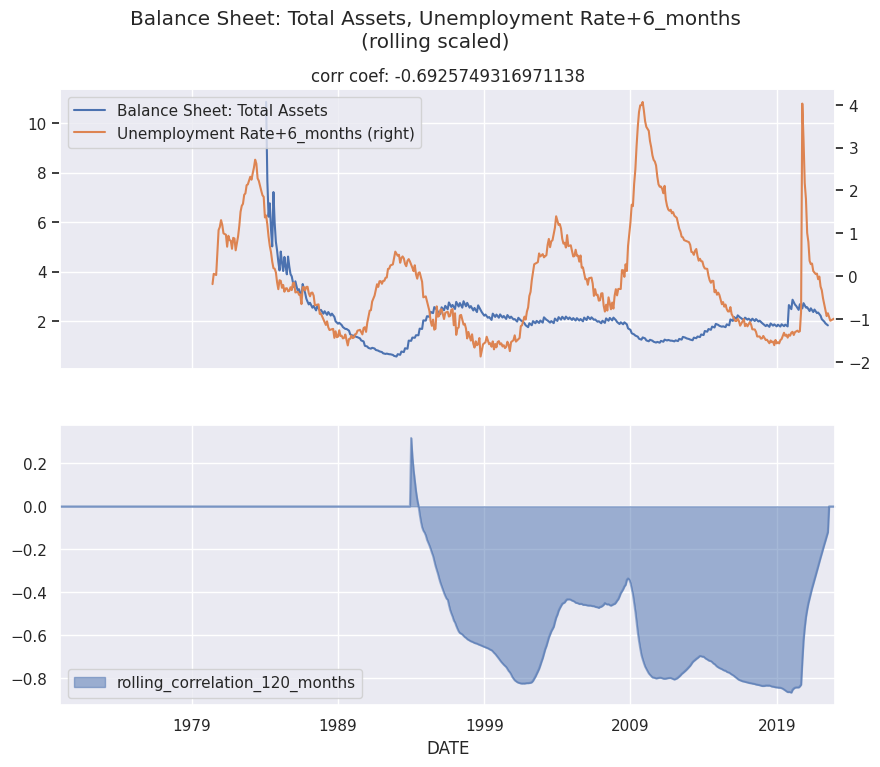

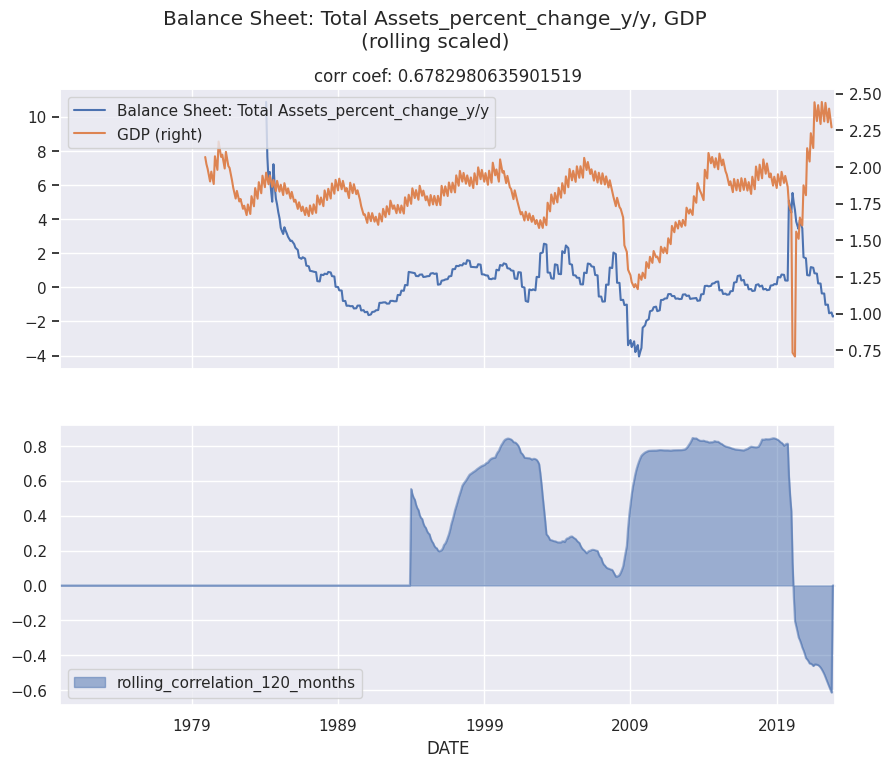

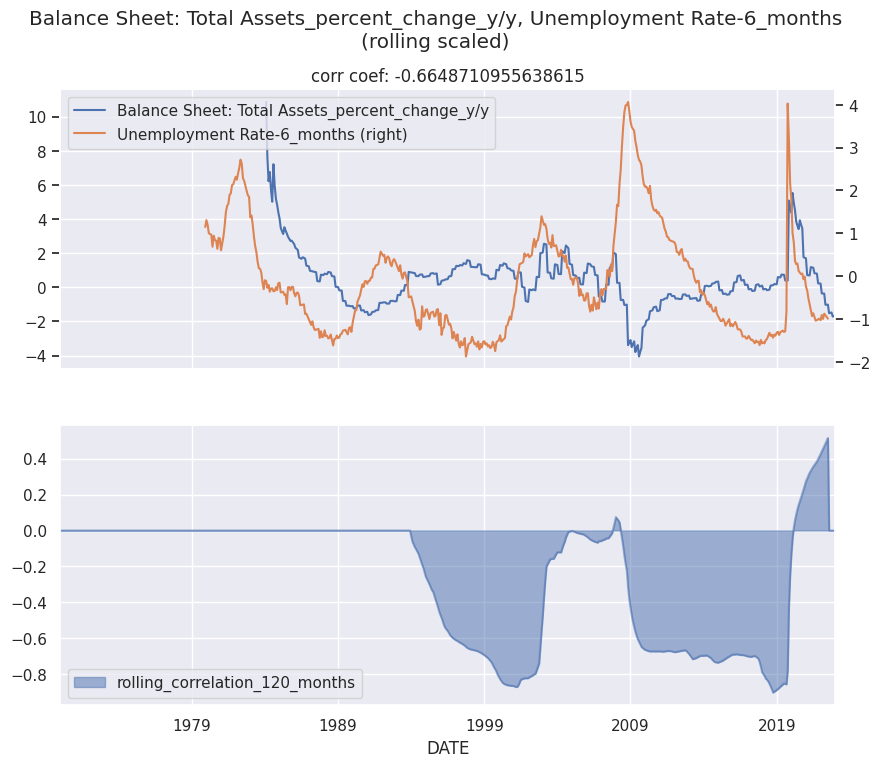

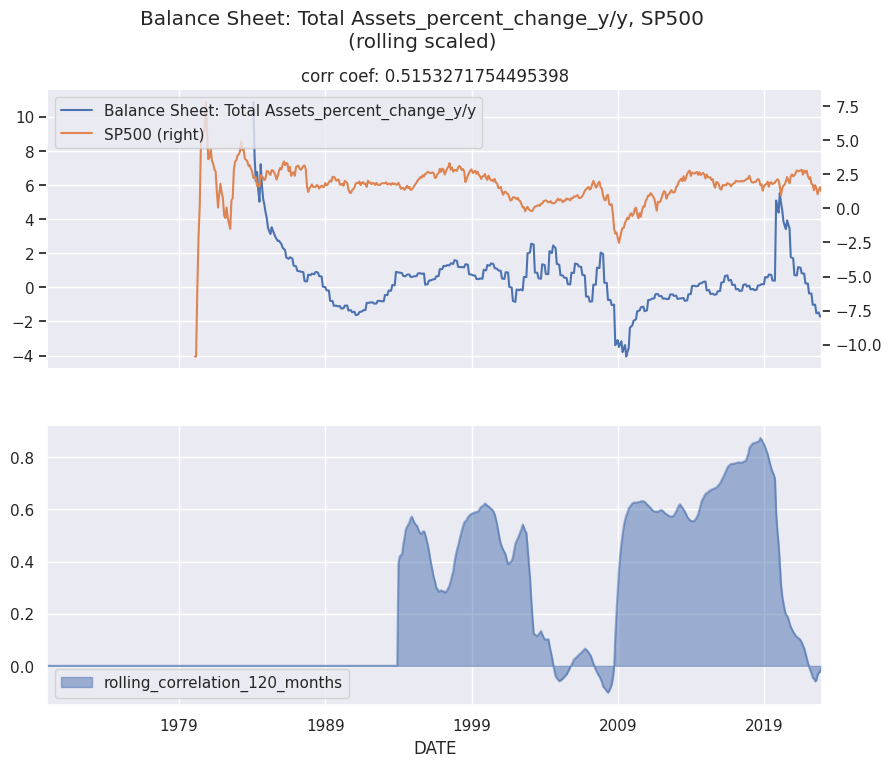

In [19]:
for col_a, col_b in corr_pair_list:
    
    figsize = (10,8)
    
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        sharex=True
    )

    ax_a = df_scaled[col_a].plot(label=col_a, figsize=figsize, ax=axes[0])

    ax_b = df_scaled[col_b].plot(label=col_b, secondary_y=True, ax=axes[0])

    h1, l1 = ax_a.get_legend_handles_labels()
    h2, l2 = ax_b.get_legend_handles_labels()

    plt.legend(h1+h2, l1+l2, loc=2)
    
    ax_c = (
        df_scaled[col_a]
        .rolling(rolling_window_month_count)
        .corr(df_scaled[col_b])
        .plot
        .area(
            label=f"rolling_correlation_{rolling_window_month_count}_months", 
            stacked=False,
            ax=axes[1]
        )
    )
    
    ax_c.legend(loc=3)
    
    corr_coef = df_corr.loc[col_b][col_a]
    plt.title(f"corr coef: {corr_coef}")
    plt.suptitle(f"{col_a}, {col_b}\n(rolling scaled)")